In [1]:
!pip install matplotlib
!pip install nltk
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install scikit-learn
!pip install imbalanced-learn
!pip install transformers
!pip install torch
!pip install sentencepiece
!pip install xgboost
!pip install pandas requests
!pip install tqdm

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 13.2 MB/s eta 0:00:0000:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 14.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 12.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib]8 [matplotlib]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [nltk]4/5 [nltk]b]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached murmurhash-1.0.12-cp313-cp313-macosx_10_13_x86_64.whl.metadata (2.1 kB)
  Using cached cymem-2.0.11-cp31

In [42]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [44]:
file_path = os.path.join(os.getcwd(), "csv's", "stat_desc.csv")
df = pd.read_csv(file_path, sep=",", low_memory=False)
df_clean = df.dropna(subset=['catégories']).copy()
df_clean['catégories'] = df_clean['catégories'].astype(int)


In [49]:
# Définir les labels des catégories
category_labels = {
    1: 'Excellence, performance, leadership',
    2: 'Accompagnement & évolution pro',
    3: 'Proximité & ancrage local',
    4: 'Relations humaines & collectif',
    5: 'Engagement social & bien-être'
}

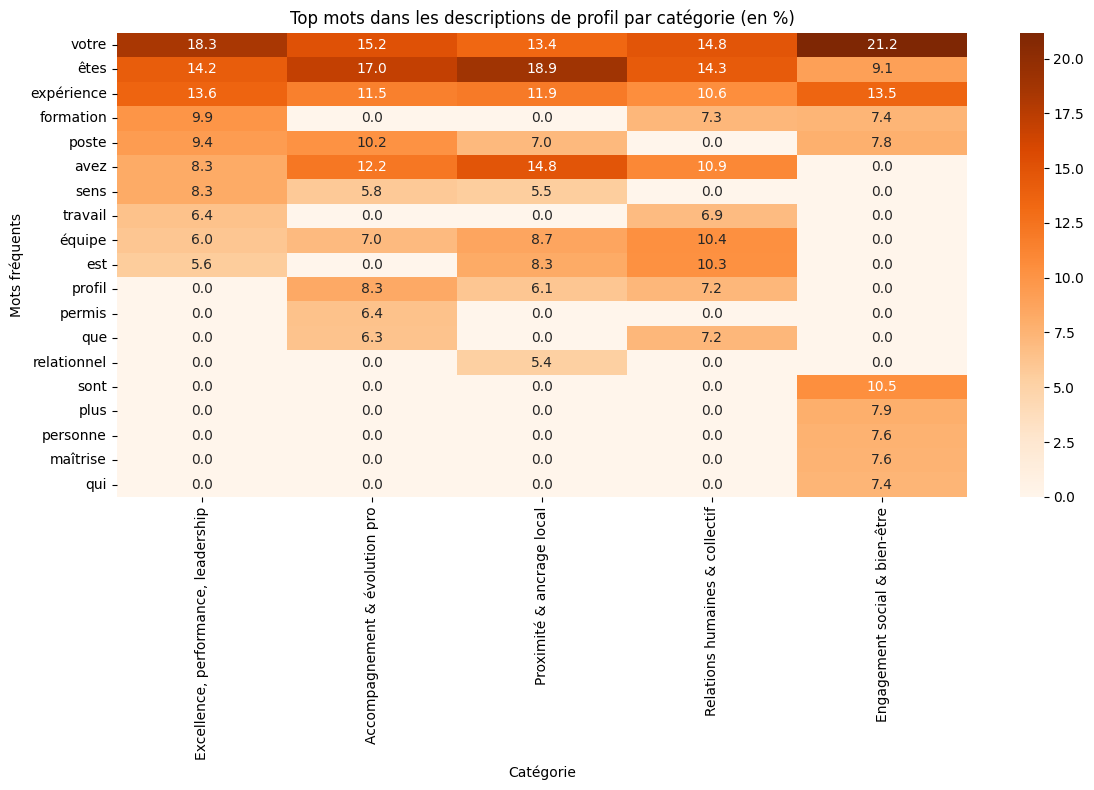

In [ ]:
# Fonction pour extraire les mots les plus fréquents par catégorie
def extract_top_words_by_category(df, column, n=10):
    words_by_cat = {}
    for cat in sorted(df['catégories'].unique()):
        text = df[df['catégories'] == cat][column].dropna().str.lower().str.cat(sep=' ')
        words = re.findall(r"\b\w+\b", text)
        stop_words = {'les','des','pour','avec','dans','sur','de','du','et','la','le','un','une','en','à','par','vous','nous'}
        filtered = [w for w in words if w not in stop_words and len(w) > 2]
        counter = Counter(filtered)
        words_by_cat[cat] = dict(counter.most_common(n))
    return pd.DataFrame(words_by_cat).fillna(0)

# Appliquer la fonction
top_words_df = extract_top_words_by_category(df_clean, 'description_profil', n=10)
# Renommer les colonnes avec les labels
top_words_df.columns = [category_labels[c] for c in top_words_df.columns]

# Transformer en pourcentages par colonne
top_words_df_pct = top_words_df.div(top_words_df.sum(axis=0), axis=1) * 100

# Afficher la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_words_df_pct, annot=True, cmap='Oranges', fmt='.1f')
plt.title("Top mots dans les descriptions de profil par catégorie (en %)")
plt.xlabel("Catégorie")
plt.ylabel("Mots fréquents")
plt.tight_layout()
plt.show()




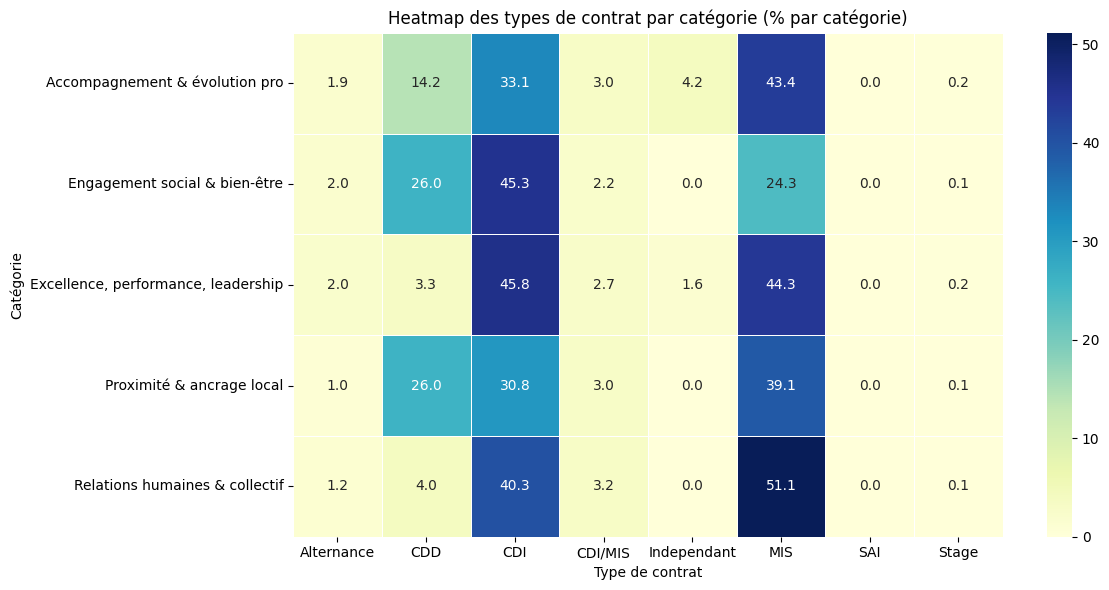

In [50]:
# Conversion et mappage des catégories
df['catégories'] = df['catégories'].astype('Int64')
df['catégorie_label'] = df['catégories'].map(category_labels)

# Création de la table croisée des types de contrat par catégorie
contract_df = df.groupby('catégorie_label')['contractType'].value_counts().unstack(fill_value=0)

# Normalisation ligne par ligne (%)
contract_percent_by_category = contract_df.div(contract_df.sum(axis=1), axis=0) * 100

# Affichage de la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(contract_percent_by_category, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title("Heatmap des types de contrat par catégorie (% par catégorie)")
plt.ylabel("Catégorie")
plt.xlabel("Type de contrat")
plt.tight_layout()
plt.show()

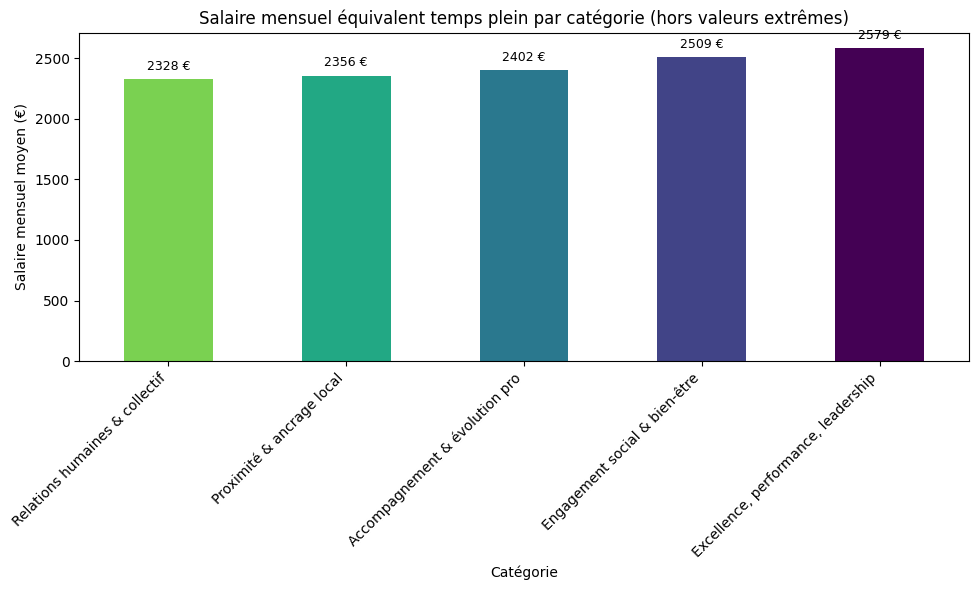

In [35]:

# Préparation des données
df['catégories'] = pd.to_numeric(df['catégories'], errors='coerce')
df['catégorie_label'] = df['catégories'].map(category_labels)
df['salary_hourly_mean'] = pd.to_numeric(df['salary_hourly_mean'], errors='coerce')

# Filtrage des valeurs extrêmes et calcul du salaire mensuel
salary_filtered = df.dropna(subset=['salary_hourly_mean', 'catégorie_label'])
salary_filtered = salary_filtered[salary_filtered['salary_hourly_mean'] < 100]
salary_filtered['salary_monthly'] = salary_filtered['salary_hourly_mean'] * 151.6666

# Moyenne mensuelle par catégorie
salary_monthly_mean = salary_filtered.groupby('catégorie_label')['salary_monthly'].mean().sort_values()

# Visualisation
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis_r(salary_monthly_mean.rank().values / salary_monthly_mean.rank().max())
salary_monthly_mean.plot(kind='bar', color=colors)
plt.title("Salaire mensuel équivalent temps plein par catégorie (hors valeurs extrêmes)")
plt.ylabel("Salaire mensuel moyen (€)")
plt.xlabel("Catégorie")
plt.xticks(rotation=45, ha='right')

# Ajouter les valeurs numériques au-dessus des barres
for i, val in enumerate(salary_monthly_mean):
    plt.text(i, val + 50, f"{val:.0f} €", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


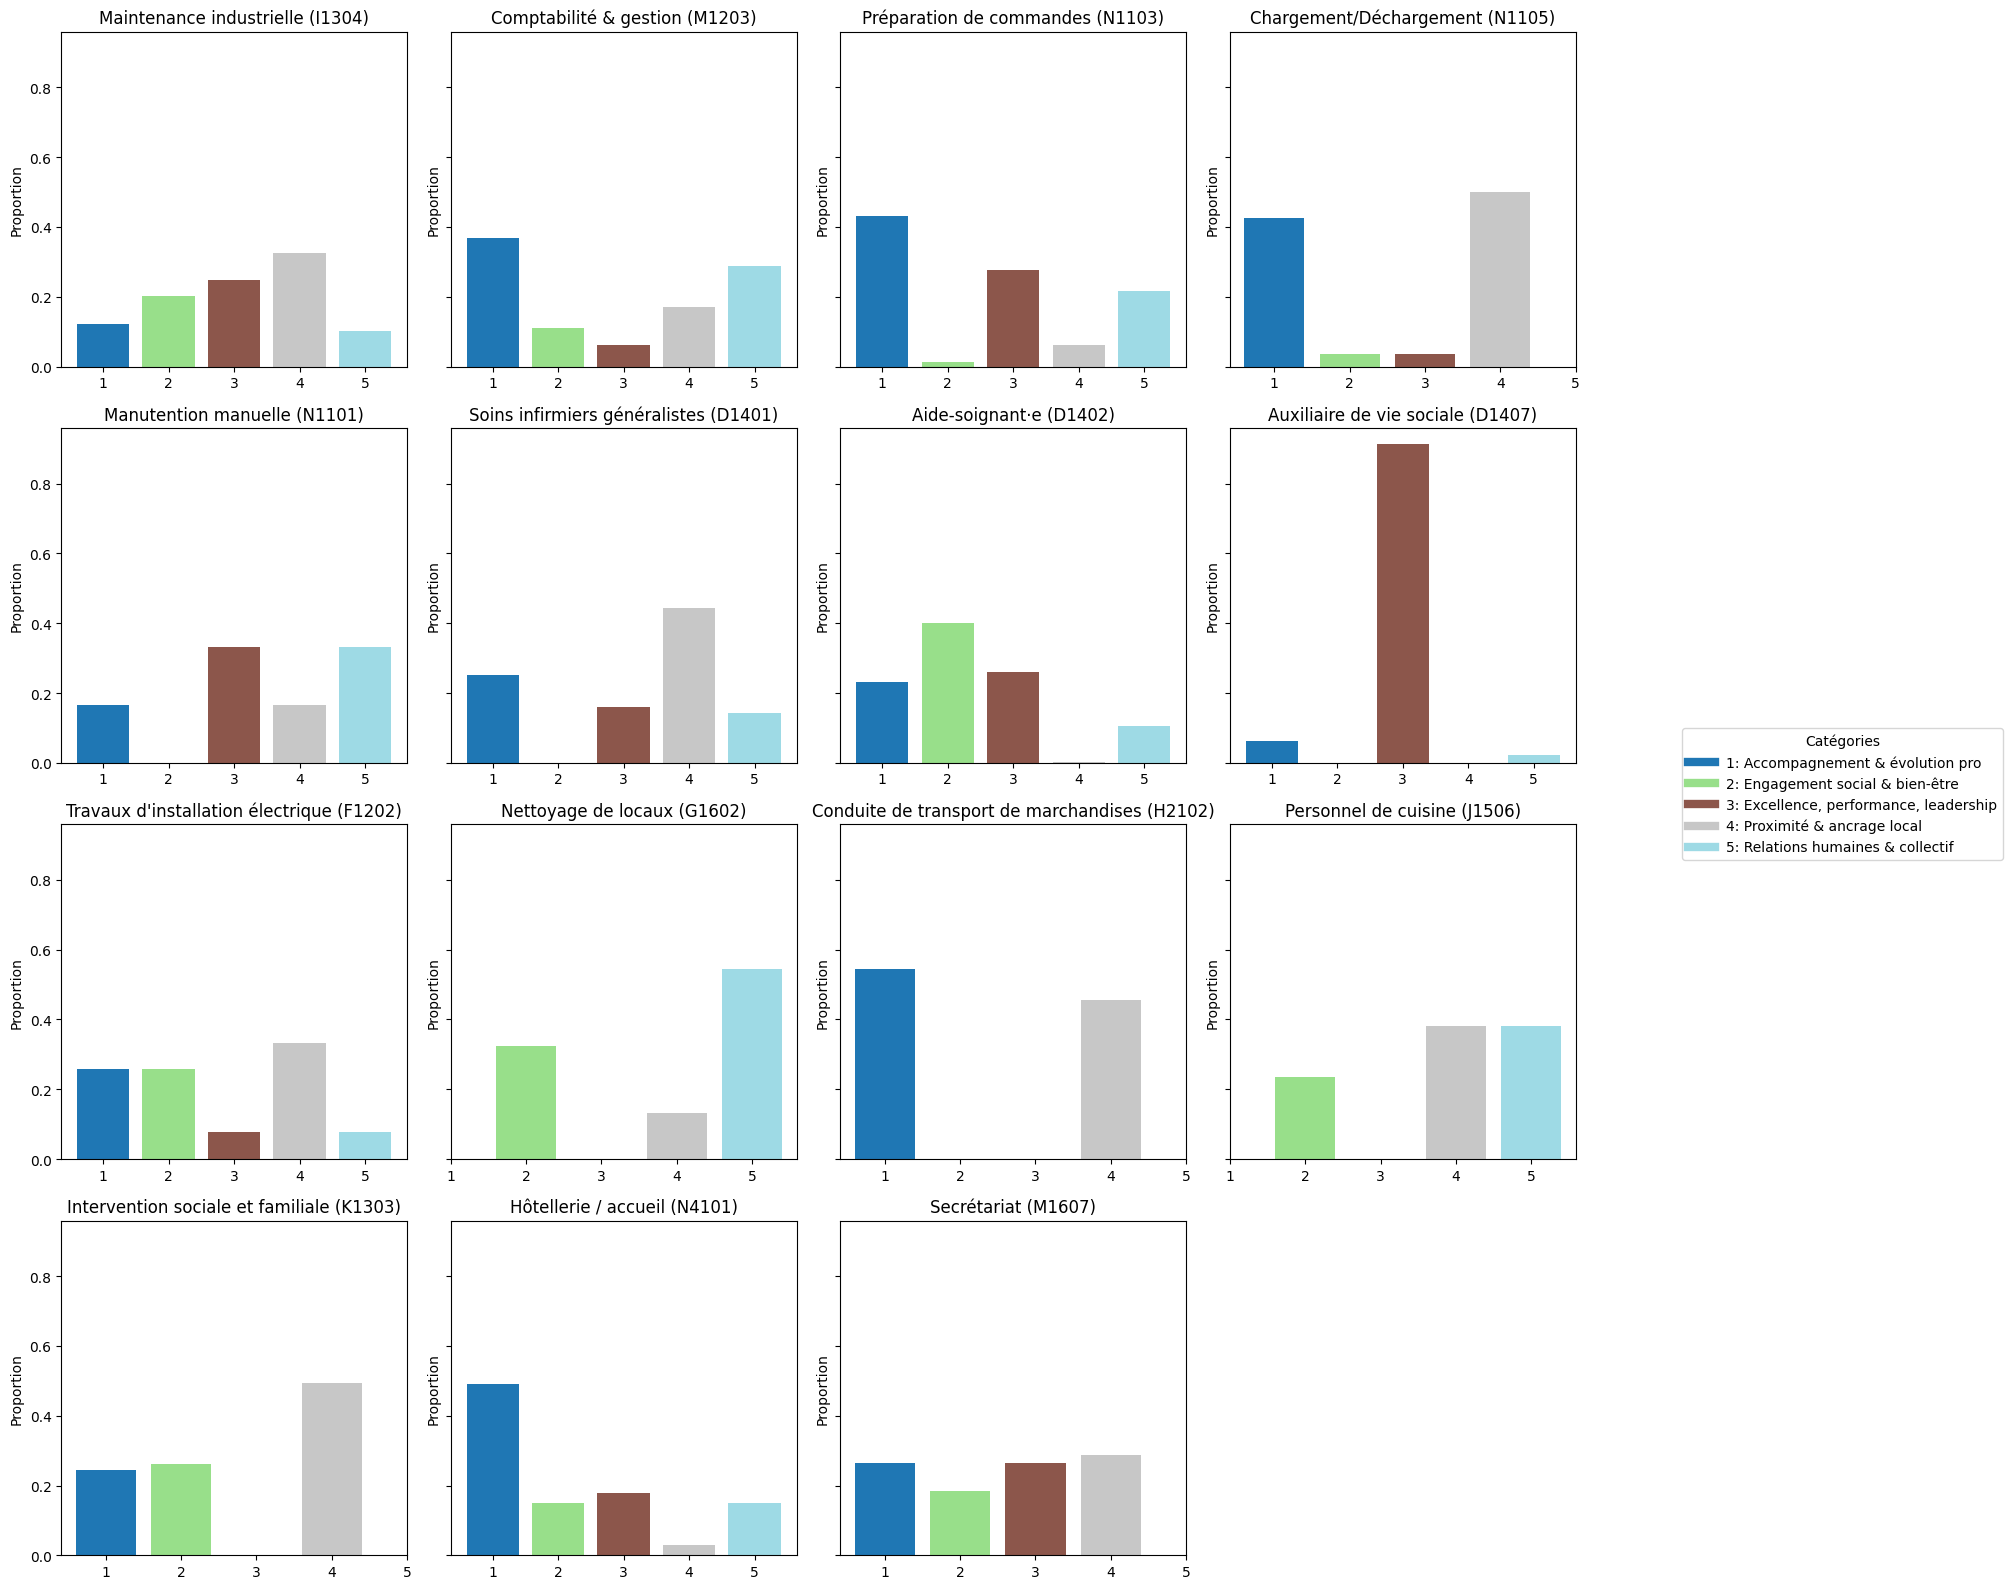

In [34]:
# Conversion et mapping
df['catégories'] = pd.to_numeric(df['catégories'], errors='coerce')
df['catégorie_label'] = df['catégories'].map(category_labels)
df['salary_hourly_mean'] = pd.to_numeric(df['salary_hourly_mean'], errors='coerce')
filtered_rome_data = df.dropna(subset=['job_ROME_code', 'catégorie_label'])

# Dictionnaire des labels simplifiés
rome_labels = {
    'I1304': "Maintenance industrielle",
    'M1203': "Comptabilité & gestion",
    'N1103': "Préparation de commandes",
    'N1105': "Chargement/Déchargement",
    'N1101': "Manutention manuelle",
    'D1401': "Soins infirmiers généralistes",
    'D1402': "Aide-soignant·e",
    'D1407': "Auxiliaire de vie sociale",
    'F1202': "Travaux d'installation électrique",
    'G1602': "Nettoyage de locaux",
    'H2102': "Conduite de transport de marchandises",
    'J1506': "Personnel de cuisine",
    'K1303': "Intervention sociale et familiale",
    'N4101': "Hôtellerie / accueil",
    'M1607': "Secrétariat"
}

codes = list(rome_labels.keys())

# Détection des catégories uniques et mapping vers numéros et couleurs
categories = sorted(filtered_rome_data['catégorie_label'].unique())
num_categories = len(categories)
colors = plt.cm.tab20(np.linspace(0, 1, num_categories))
cat_to_num = {cat: i for i, cat in enumerate(categories, start=1)}
cat_to_color = {cat: colors[i-1] for i, cat in enumerate(categories, start=1)}

# Création des subplots
n = len(codes)
ncols = 4
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows), sharey=True)
axes = axes.flatten()

for ax, code in zip(axes, codes):
    data = filtered_rome_data[filtered_rome_data['job_ROME_code'] == code]
    dist = data['catégorie_label'].value_counts(normalize=True)
    nums = [cat_to_num[cat] for cat in dist.index]
    cols = [cat_to_color[cat] for cat in dist.index]
    ax.bar(nums, dist.values, color=cols)
    ax.set_title(f"{rome_labels[code]} ({code})")
    ax.set_xticks(range(1, num_categories + 1))
    ax.set_xticklabels(range(1, num_categories + 1))
    ax.set_xlabel("")
    ax.set_ylabel("Proportion")

# Supprimer les subplots non utilisés
for ax in axes[n:]:
    fig.delaxes(ax)

# Légende globale
handles = [plt.Line2D([0], [0], color=cat_to_color[cat], lw=6) for cat in categories]
legend_labels = [f"{cat_to_num[cat]}: {cat}" for cat in categories]
fig.legend(handles, legend_labels, title="Catégories", bbox_to_anchor=(1.05, 0.5), loc="center left")

plt.tight_layout()
plt.show()


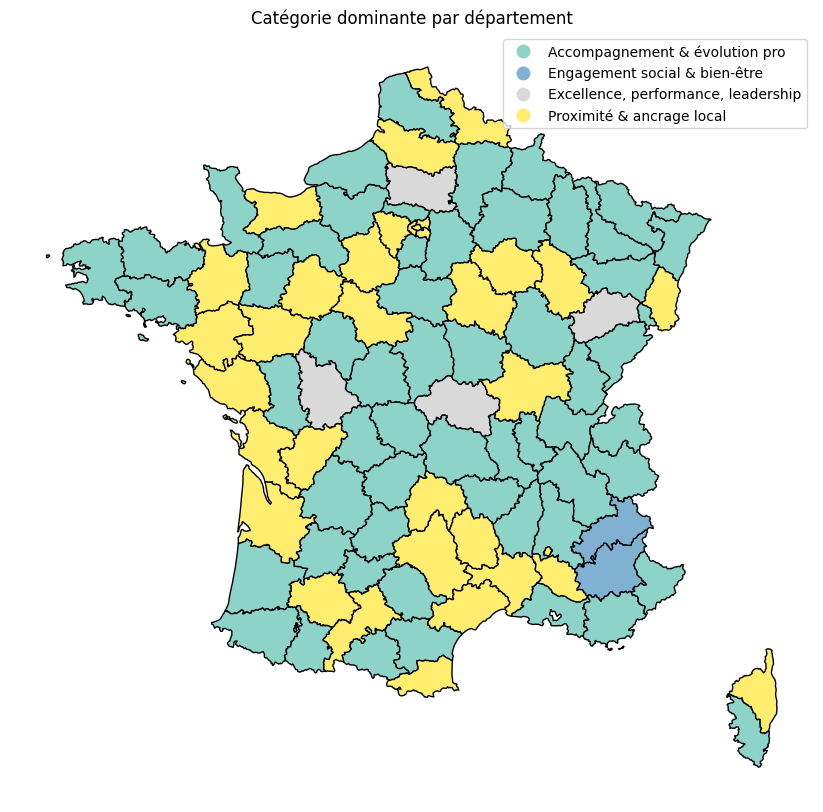

In [40]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Définir les labels des catégories
category_labels = {
    1: 'Excellence, performance, leadership',
    2: 'Accompagnement & évolution pro',
    3: 'Proximité & ancrage local',
    4: 'Relations humaines & collectif',
    5: 'Engagement social & bien-être'
}

# Déterminer la catégorie dominante par département
dominant_category = df.groupby('location_departement')['catégories'] \
                      .agg(lambda x: x.value_counts().idxmax()) \
                      .map(category_labels).reset_index()
dominant_category.columns = ['code', 'catégorie_majoritaire']
dominant_category['code'] = dominant_category['code'].astype(str).str.zfill(2)

# Charger la carte des départements (fichier GeoJSON en ligne)
geojson_url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
departements = gpd.read_file(geojson_url)

# Fusionner les données avec la carte
departements = departements.merge(dominant_category, left_on='code', right_on='code')

# Afficher la carte
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
departements.plot(column='catégorie_majoritaire', legend=True, ax=ax, cmap='Set3', edgecolor='black')
plt.title("Catégorie dominante par département")
plt.axis('off')
plt.show()


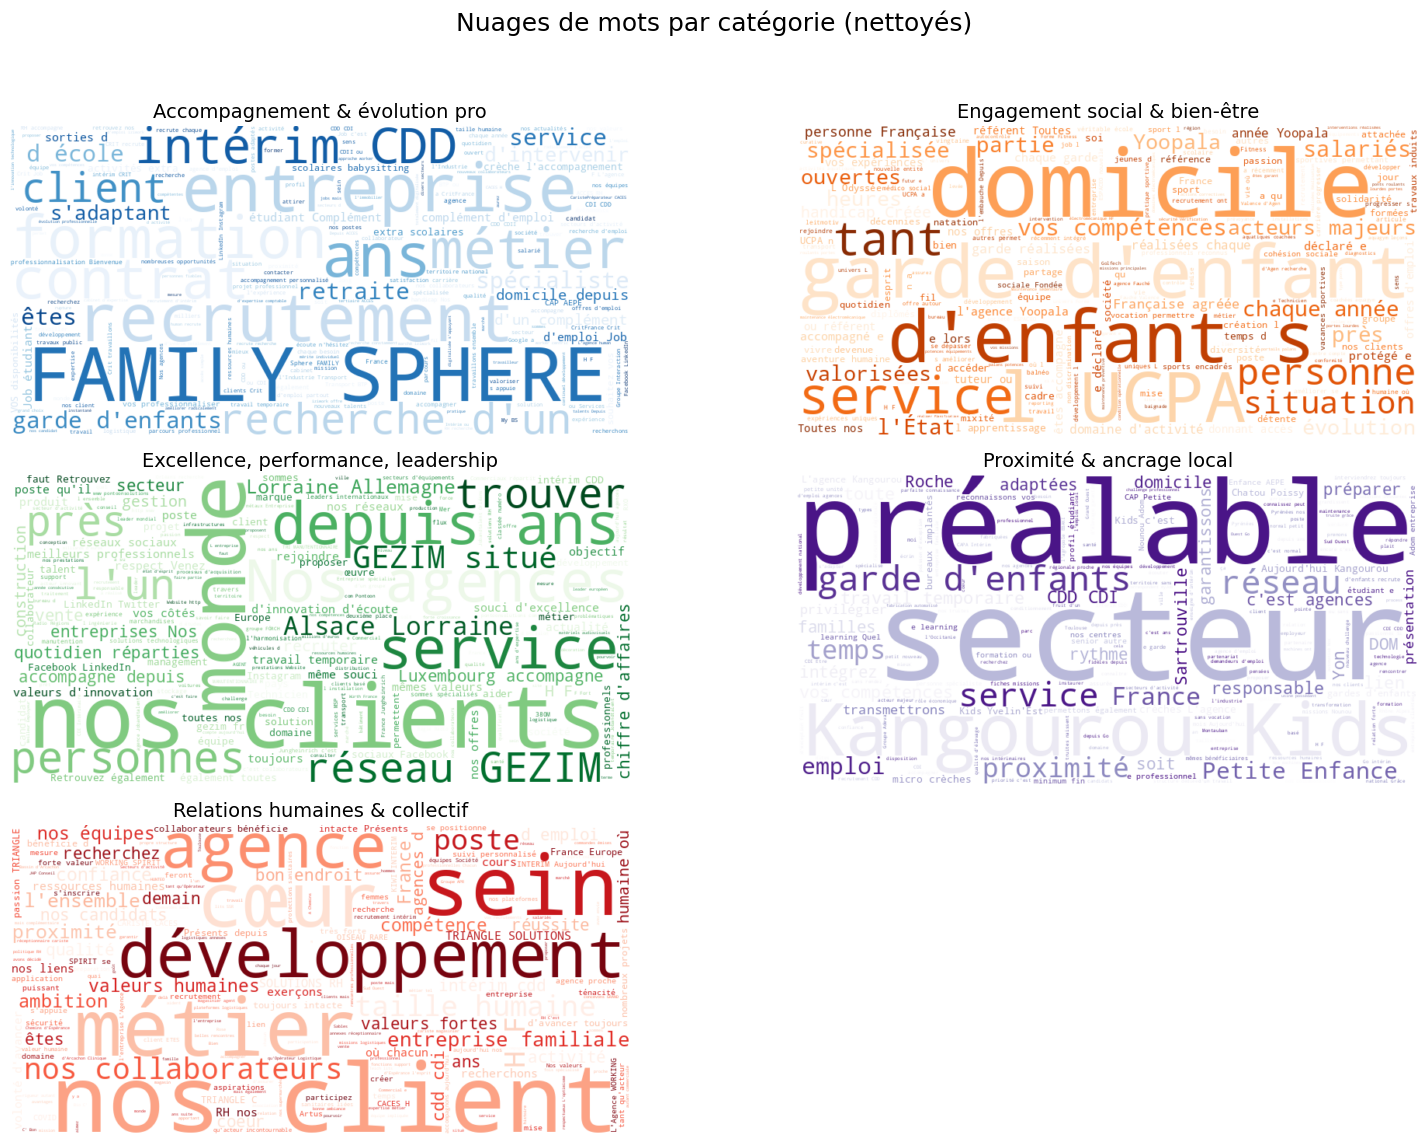

In [51]:


# Liste de mots à ignorer (stopwords personnalisés)
custom_stopwords = set([
    "le", "la", "les", "un", "une", "des", "de", "du", "dans", "au", "aux", "en", "et", "à", "pour",
    "avec", "par", "sur", "ce", "cette", "ces", "qui", "que", "quoi", "dont", "nous", "vous", "ils",
    "elles", "il", "elle", "on", "ne", "pas", "plus", "moins", "être", "avoir", "fait", "faites", 
    "est", "sont", "été", "comme", "chez", "leurs", "ses", "son", "sa", "notre", "votre", "leurs",
    "afin", "tout", "tous", "aussi", "auprès", "ainsi", "veut", "souhaite", "propose", "proposons",
    "etc", "d’un", "d'une", "leur", "lui", "celle", "ceux"
])

# Générer les textes par catégorie
category_texts = df.groupby('catégorie_label')['description_entreprise'].apply(lambda x: ' '.join(x.dropna()))

# Couleurs différentes par catégorie
colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Reds']

# Génération des nuages de mots
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (cat, text) in enumerate(category_texts.items()):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colors[i % len(colors)],
        stopwords=custom_stopwords
    ).generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(cat, fontsize=14)
    axes[i].axis('off')

for j in range(len(category_texts), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Nuages de mots par catégorie (nettoyés)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


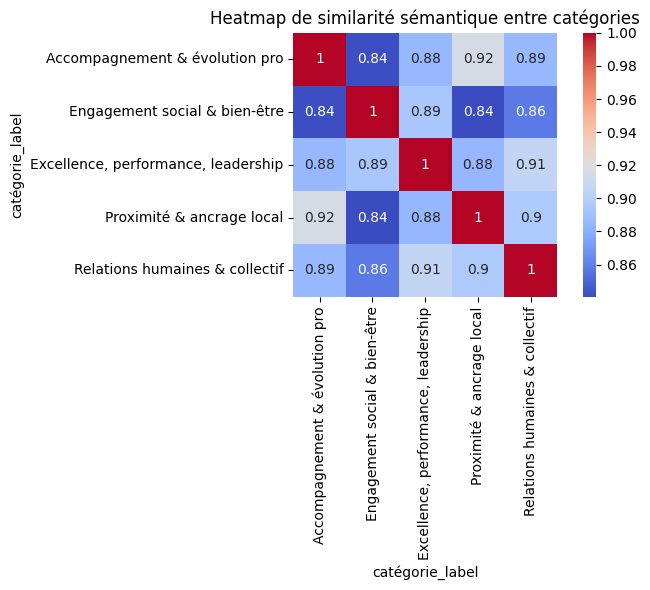

In [52]:
# Générer les textes par catégorie
category_texts = df.groupby('catégorie_label')['description_entreprise'].apply(lambda x: ' '.join(x.dropna()))

# Vectorisation avec stopwords anglais (compatible sklearn)
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(category_texts)

# Calcul de la similarité cosinus
similarity_matrix = cosine_similarity(X)

# Création de la heatmap
sim_df = pd.DataFrame(similarity_matrix, index=category_texts.index, columns=category_texts.index)

plt.figure(figsize=(8, 6))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', square=True)
plt.title("Heatmap de similarité sémantique entre catégories")
plt.tight_layout()
plt.show()
